<a href="https://colab.research.google.com/github/tszabad/IBS_deeplearning_assignment/blob/main/Home_assignment_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home assignment - Machine Learning (ITLB356, MIB)
## Tamás Szabados
Getting the best results on the fashion-MNIST dataset

# Importing necessary libraries

In [ ]:
!pip install -q -U tensorflow>=1.8.0
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.callbacks import EarlyStopping


import os
import gzip

In [ ]:
np.random.seed(42)

# Downloading data

In [ ]:
! wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
! wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
! wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
! wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz


--2021-08-23 16:23:20--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.140.108
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.140.108|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  11.8MB/s    in 2.1s    

2021-08-23 16:23:23 (11.8 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2021-08-23 16:23:23--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.140.108
Connecting to fashion-mnist.s3-website.eu-central-1.a

# Loading data

In [ ]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`.
    """
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels


In [ ]:
train_images, train_labels = load_mnist('.')
train_images = train_images / 255.

valid_test_images, valid_test_labels = load_mnist('.', 't10k')

valid_test_images = valid_test_images / 255. # the same normalization for valid and test

valid_images = valid_test_images[:5000]
valid_labels = valid_test_labels[:5000]
test_images = valid_test_images[5000:]
test_labels = valid_test_labels[5000:]


In [ ]:
train_images.shape

(60000, 784)

### Getting the shape of the input

In [ ]:
train_images[0].shape

(784,)

### Getting the number of classes

In [ ]:
pd.unique(train_labels)


array([9, 0, 3, 2, 7, 5, 1, 6, 4, 8], dtype=uint8)

# Models with `fully connected` **Dense** layers

### Saving the best model accuracy and model name into variables

In [ ]:
best= 0. #best accuracy
best_model = ""  #best model

## The **basic model** for testing with only two `Dense` layers

Since this is a multy class classification task with 10 labels (integer (class number), I will use in all models the "sparse_categorical_crossentropy" loss function and the Softmax activation for the last layer. In this model I will use the Adam optimizer and 15 epochs.

In [ ]:
batch_size= 256

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512, input_shape=(784,), activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(train_images, train_labels, 
          epochs=15, 
          batch_size = batch_size, 
          validation_data=(valid_images, valid_labels),
          verbose = 1)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("test accurancy: ", test_acc)

if test_acc > best:
  best = test_acc
  best_model = "basic model"
  model.save('my_model.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
235/235 [==============================] - 1s 3ms/step - loss: 0.5440 - accuracy: 0.8117 - val_loss: 0.4558 - val_accuracy: 0.8432
Epoch 2/15
235/235 [==============================] - 1s 3ms/step - loss: 0.3920 - accuracy: 0.8611 - val_loss: 0.4169 - val_accuracy: 0.8496
Epoch 3/15
235/235 [==============================] - 1s 3ms/step - loss: 0.3521 - accuracy: 0.8745 - val_loss: 0.3721 - val_accuracy: 0.8688
Epoch 4/15
235/235 [==============================] - 1s 3ms/step - loss: 0.3196 - a

The basic model has managed to achieve 89,3% accuracy on test data. <br/>I managed to achive this **result with batch size of 256 and 512 units** in the dense layer. <br/> I tried other parameters (64, 128, 256) for batch size and units, but with that parameters the model had less accuracy. <br/> I tried sigmoid activation function on the basic model as well, but **relu had better accuracy**. Since I use Adam optimizer I chose only 15 epochs to train the model.

## Gird Search for the first model

Before creating the grid search I tried the sigmoid activation function on the basic model, but relu had better accuracy. So in the grid search I will use the relu activation functions in the hidden layers. <br/>
I added a new Dense layer and two dropout layer as well to the model to try to increase accuracy.<br/>
With the grid search I will look for optimal hyperparameters for batch size, units, dropout rate and otimizer.


In [ ]:
# this cell runs for 29 minutes !!!
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier

# getting the 20% of train data
X_grid, X_notused, y_grid, y_notused = train_test_split(train_images, train_labels, test_size=0.8, stratify = train_labels, random_state=42)

batch_size= [64, 128, 256, 512]
units = [128, 256, 512]
dropout = [0.1, 0.15, 0.2, 0.3]
opt = ["adam", "SGD", "adadelta"]

def build_model(opt, dropout, units, batch_size):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(units, input_shape=(784,), activation='relu'))
  model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.Dense(32, activation='relu'))
  model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model

model = KerasClassifier(build_fn=build_model, epochs=30,  verbose=0)


param_grid = dict(opt=opt,  dropout = dropout, units= units,  batch_size = batch_size )
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_grid, y_grid)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.871667 using {'batch_size': 64, 'dropout': 0.1, 'opt': 'adam', 'units': 256}


### Results of Grid search
* Best: 0.871667 using: 'batch_size': 64, 'dropout': 0.1, 'opt': 'adam', 'units': 256

## First model

In the first model I am testing the model with the grid search output parameters.  
I added early stopping with a patience of 10 epochs to avoid overfitting of the model and I set a learning rate of 0.002 to the Adam optimizer as well.

In [ ]:
batch_size= 64
learning_rate = 0.002

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256, input_shape=(784,), activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()

adam = = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit(train_images, train_labels, 
          epochs=30, 
          batch_size = batch_size, 
          validation_data=(valid_images, valid_labels),
          verbose = 1,
          callbacks = [es])
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("test accurancy: ", test_acc)
if test_acc > best:
  best = test_acc
  best_model = "first"
  model.save('my_model.h5')

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 32)                8224      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 10)                330       
Total params: 209,514
Trainable params: 209,514
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
938/938 [==============================] - 4s 4ms/step - loss: 0.5477 - accuracy: 0.8038 - val_loss: 0

## Defining a function to plot train and validation accuracy and loss

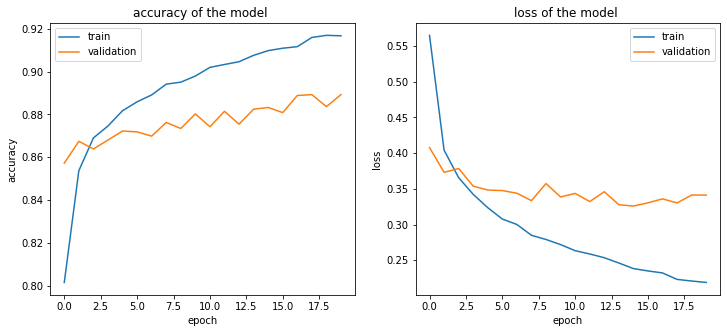

In [ ]:
def plothistory(history):
  plt.figure(figsize = (12,5))
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('accuracy of the model ')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='best')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('loss of the model ')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='best')

plothistory(history)


The model managed to achive 89,06% accuracy. The plot shows that after 2 epochs the validation accuracy goes below train accuracy and it increases less slowly than train accuracy afterwards.

## Second model

To increase accuracy, I added **4 additional hidden layers** to the model, 1 more dropout and 3 dense layers. This time I used sigmoid activation function as well in one of the hidden layers, because I found that it improves the model's accuracy. I **changed the probability of the first dropout function** to 0.6, to 0.3 the second and 0.2 the third, because I found that it makes the model more accurate. I used the adam optimizer function with the default parameters in this case.

In [ ]:
batch = 64

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256, input_shape=(784,), activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='sigmoid'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.6))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)


model.summary()
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    train_images, train_labels, 
    epochs=30, 
    batch_size = batch_size, 
    validation_data=(valid_images, valid_labels), 
    verbose = 1, 
    callbacks = [es])

test_loss, test_acc = model.evaluate(test_images, test_labels)
print("test accuracy: ", test_acc)

if test_acc > best:
  best = test_acc
  best_model = "second"
  model.save('my_model.h5')

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_86 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_87 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_33 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_89 (Dense)             (None, 64)              

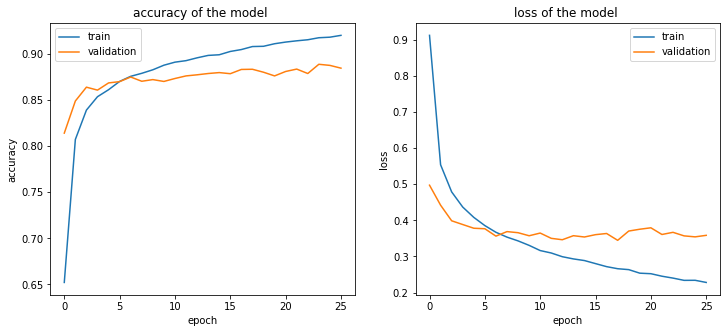

In [ ]:
plothistory(history)

The second model managed to achive 89,78% accuracy, so with adding more layers I managed to improve the model's performance slightly. The plot above shows that with this model I managed to decrease the difference of train and validation accuracy and loss.

## Third model

Unfortunatly, I did not managed to achive better results than 89,78% with the models with adam optimizer, so I decided to build a model with the SGD optimizer.
This time I will not use Grid Search, but go on a trial and error way, when deciding on the model hyperparameters. In this model I will use LearningRateSheduler and early stop as well.

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
learning_rate = 0.01
batch_size= 192

I found that in case of the SGD optimizer I have to use bigger batch size and the best size I found for this model is 192. I set learning rate to 0.01.

In [ ]:
def scheduler(epoch, learning_rate):
  if epoch < 4:
    return learning_rate*1.5
  elif epoch < 10:
    return learning_rate
  else:
    return learning_rate * tf.math.exp(-0.1)

I found that until 4 epochs a higher learning rate can be used, which has to be decreased after it, and than again decrease after the tenth epoch.

In [ ]:

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, input_shape=(784,), activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(10, activation='softmax'))


model.summary()
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(optimizer=sgd, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    train_images, train_labels, 
    epochs=25, 
    batch_size = batch_size, 
    validation_data=(valid_images, valid_labels), 
    callbacks = [es, callback] )

test_loss, test_acc = model.evaluate(test_images, test_labels)
print("test accuracy: ", test_acc)
if test_acc > best:
  best = test_acc
  best_model = "third"
  model.save('my_model.h5')

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_118 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_48 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_119 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_49 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_120 (Dense)            (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_______________________________________________

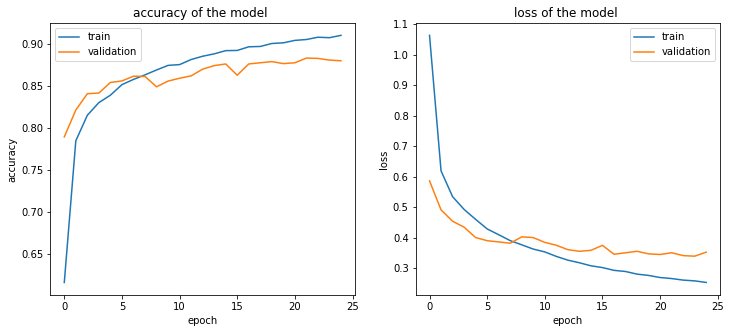

In [ ]:
plothistory(history)

This model managed to reach 88,55% accuracy on test data, which is worser than with the previous models, but the train accuracy and loss is closer to validation accuracy and loss. Until seven epochs the validaton accuracy and loss is better than train accuracy and loss.

## Fourth model

To increase accuracy I tried again to add more layers, so I added 4 additional hidden layers to the model: 1 more dropout and 3 dense layers. <br/>This time I used sigmoid activation function as well in one of the hidden layers, because I found that it improves the model's accuracy. <br/>  I changed the probability of the first dropout function to 0.5, the others to 0.4 because I found that it makes the model better.<br/>
I realized that increasing the batch size to 256 imporves furher the accuracy of the model.

In [ ]:
batch_size= 256
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256, input_shape=(784,), activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(256, activation='sigmoid'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(optimizer=sgd, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    train_images, train_labels, 
    epochs=50, 
    batch_size = batch_size, 
    validation_data=(valid_images, valid_labels), 
    verbose = 1, 
    callbacks = [es, callback])

test_loss, test_acc = model.evaluate(test_images, test_labels)
print("test accuracy: ", test_acc)
if test_acc > best:
  best = test_acc
  best_model = "fourth"
  model.save('my_model.h5')

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 256)               200960    
_________________________________________________________________
dense_122 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_123 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_50 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_124 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_51 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_125 (Dense)            (None, 64)              

This model managed to achive 88,98% accuracy. <br>
With SGD (stochastic gradient descent) optimizer and the layers added, I managed to decrease the gap between train and validation accuracy and loss furher. Until eleven epochs the validaton accuracy and loss is better than train accuracy and loss.

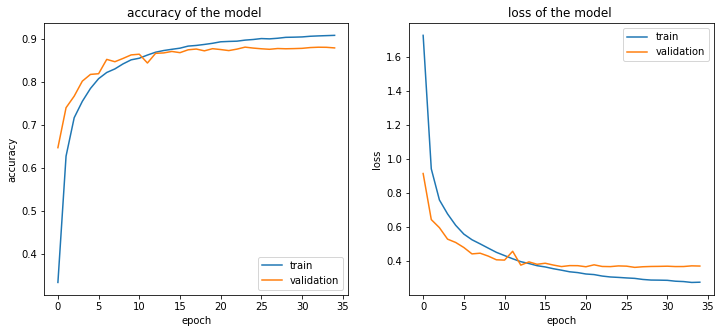

In [ ]:
plothistory(history)

## Checking for the best model

In [ ]:
print('\n Best test accuracy:', best)
print("The best_model is the " + best_model+ " model.")



 Best test accuracy: 0.8978000283241272
The best_model is the second model.


# Fifth model

I found that the second model has the highest accuracy, so I will try to improve that model further, by changing activation functions, batch size and dropout rate.

In [ ]:
batch = 64
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256, input_shape=(784,), activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(256, activation='sigmoid'))
model.add(tf.keras.layers.Dense(128, activation='elu'))
model.add(tf.keras.layers.Dropout(0.6))
model.add(tf.keras.layers.Dense(64, activation='elu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(64, activation='elu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

model.summary()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    train_images, train_labels, 
    epochs=30, 
    batch_size = batch_size, 
    validation_data=(valid_images, valid_labels), 
    verbose = 1, 
    callbacks = [es])

test_loss, test_acc = model.evaluate(test_images, test_labels)
print("test accuracy: ", test_acc)

if test_acc > best:
  best = test_acc
  best_model = "fifth"
  model.save('my_model.h5')

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_127 (Dense)            (None, 256)               200960    
_________________________________________________________________
dense_128 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_129 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_53 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_130 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_54 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_131 (Dense)            (None, 64)              

With elu and selu activation I did not managed to imporve the model accuracy, with selu it was around 88-89%, with elu it was almost as good as with relu.
I tried to add other layers and change batch size and dropout ratio, but it did not improved the accuracy of the model.  
**To achive higher accuracy convolutional neural network** model should be used.

In [ ]:
print('\n Best test accuracy:', best)
print("The best_model is the " + best_model+ " model.")


 Best test accuracy: 0.8978000283241272
The best_model is the second model.


## Loading the best model for testing predictions

In [ ]:
new_model = tf.keras.models.load_model('my_model.h5')

predictions = new_model.predict(test_images)

In [ ]:
test_images.shape

(5000, 784)

## Adding figures to show predictions and actual labels

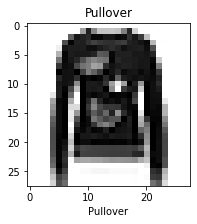

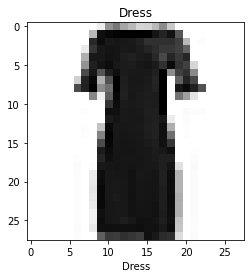

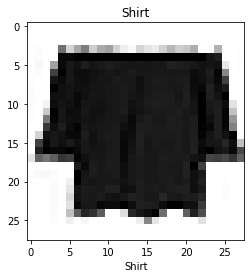

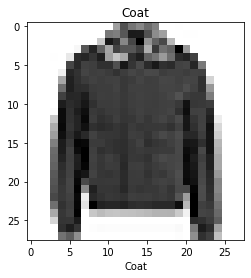

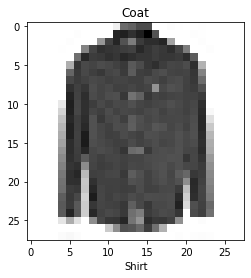

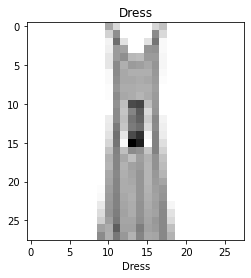

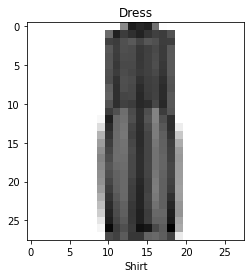

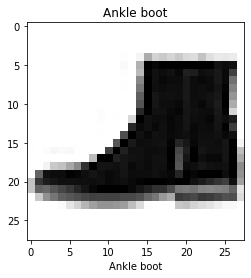

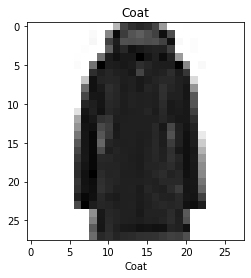

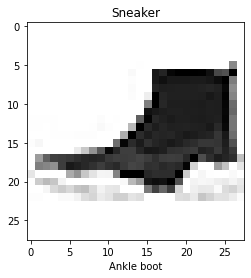

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
test_images = test_images.reshape([5000,28,28])

plt.figure(figsize=(3,3))
for i in range(10):
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[test_labels[i]])
    plt.title(class_names[np.argmax(predictions[i])])
    plt.show()

# Image prediction with Gradio

In [ ]:
pip install gradio

     |████████████████████████████████| 3.4 MB 8.7 MB/s 
     |████████████████████████████████| 206 kB 71.2 MB/s 
     |████████████████████████████████| 1.9 MB 58.4 MB/s 
     |████████████████████████████████| 3.2 MB 46.2 MB/s 
     |████████████████████████████████| 63 kB 2.9 MB/s 
     |████████████████████████████████| 961 kB 42.5 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4710 sha256=46d19295647b2f74650bfd9fc40e6e8ad881f9ce6880bfa1c64bd3106b380aed
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-py3-none-any.whl size=3371 sha256=6559681eb49c0e537ec745f418a7d064f8e90b87107dad332383607f36493ef8
  Stored in directory: /root/.cache/pip/wheels/28/c0/c4/44687421dab41455be93112bd1b0dee1f3c5a9aa27bee63708
Successfully built ffmpy flask-cachebuster


In [ ]:
import gradio as gr

In [ ]:
new_model = tf.keras.models.load_model('my_model.h5')

In [ ]:
def recognize_image(image):
    rgb_weights = [0.2989, 0.5870, 0.1140]
    img = image / 255
    img = np.mean(img, axis=2)
    img = img.reshape(1,784)
    prediction = new_model.predict(img).tolist()[0]
    return class_names[np.argmax(prediction)]
    

In [ ]:
iface = gr.Interface(
    recognize_image, 
    gr.inputs.Image(shape=(28, 28)), 
    outputs="text",
    capture_session=True,
    interpretation="default",)
iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://59490.gradio.app
Interface loading below...
